
## Print figures of coarsened Himawari cloud mask

Link to himawari segment definitions: [here](http://www.data.jma.go.jp/mscweb/en/himawari89/cloud_service/cloud_service.html)


In [1]:
import os,sys
from glob import glob
#
import xarray as xr
from dask import compute, delayed
#from dask.distributed import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
# 
from datetime import datetime
#
try:
    from satpy import Scene
except:
    print('satpy not available')
#
from utils import *

# tmp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

r2d = 180./np.pi

In [2]:
# data path
dpath = '/home/datawork-lops-osi/data/hw/mask/'
figdir = '/home1/datawork/aponte/hw/figs/'
#
dpath = './himawari/'
figdir = './figs/'

# uncompress files if necessary
filenames = []
for path, dirs, files in os.walk(dpath):
    for f in files:
        if f.split('.')[-1]=='bz2':
            print('uncompress ' +os.path.join(path,f))
            uncompress(path,f)
            filenames.append(os.path.join(path,f))
        elif f.split('.')[-1]=='DAT':
            filenames.append(os.path.join(path,f))

print('Number of files available: %d' %len(filenames))
Nfiles = len(filenames)
print('Number of files processed: %d' %len(filenames))

# extract time, band and segment numbers
time = [datetime.strptime(f.split('/')[-1].split('_B')[0], 'HS_H08_%Y%m%d_%H%M') for f in filenames]
band = [int(f.split('/')[-1].split('_B')[1].split('_')[0]) for f in filenames]
segment = [int(f.split('/')[-1].split('_S')[1][:2]) for f in filenames]


Number of files available: 40
Number of files processed: 40


--- 

## Inspect one file

In [3]:
i = 0
f, t, b, s = filenames[i], time[i], band[i], segment[i]
ds, band = read_hw_bin(f, t, blon=(105.,125.), blat=(-40.,-14))
print(ds)

<xarray.Dataset>
Dimensions:    (x: 3768, y: 1461)
Dimensions without coordinates: x, y
Data variables:
    B03        (y, x) float32 3.0000002 3.5882351 3.0588233 2.9411764 ...
    longitude  (y, x) float64 105.0 105.0 105.0 105.0 105.0 105.0 105.0 ...
    latitude   (y, x) float64 -14.0 -14.0 -14.0 -14.0 -14.0 -14.0 -14.0 ...


Sun zenith location: lon=92.1, lat=4.6
Himawari position: sublong=140.605619 sublat=0.000698


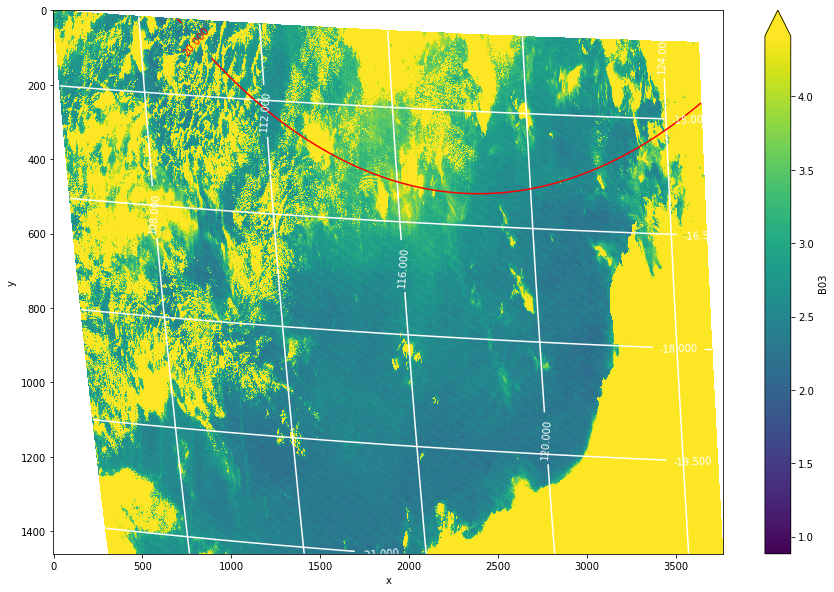

In [4]:
# computes relevant angles
angles, sun, hw = get_reflection_angles(ds['longitude'], ds['latitude'], t)

fig = plt.figure(figsize=(15,10))
dmin = ds[band].min()
ds[band].plot.pcolormesh(vmin=dmin,vmax=dmin*5)
im = ds['longitude'].plot.contour(colors='w',add_labels=True)
im.clabel()
im = ds['latitude'].plot.contour(colors='w')
im.clabel()

#(angles['angle2spec']*r2d).plot.contour(levels=[0.,15.,30.], colors=['r'])
im = (angles['angle2spec']*r2d).plot.contour(levels=[0.,10.,20.,30.], colors=['r'],add_labels=True)
im.clabel()

plt.gca().invert_yaxis()


---

## loop around all files

Sun zenith location: lon=92.1, lat=4.6
Himawari position: sublong=140.605619 sublat=0.000698


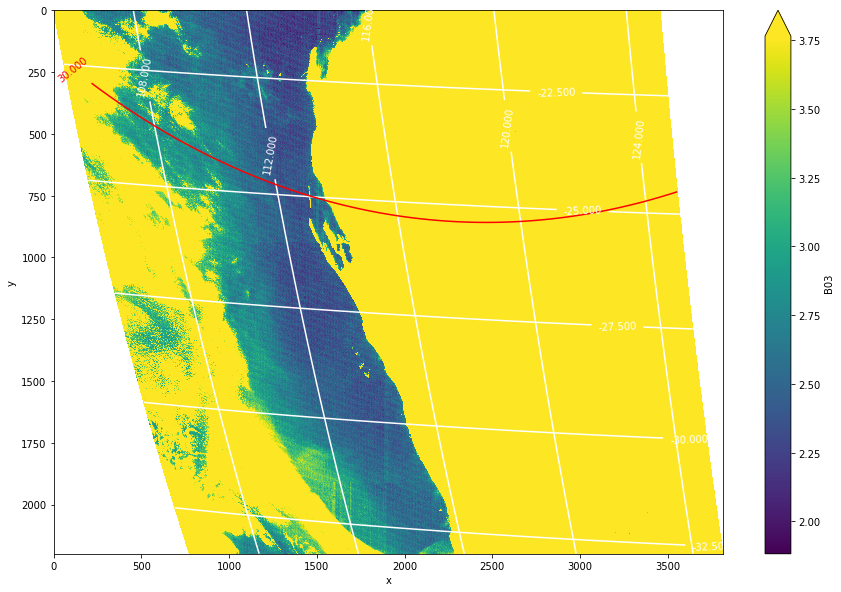

In [5]:
for f, t, b, s in zip(filenames, time, band, segment):

    if s is 8:
        
        # load data
        ds, band = read_hw_bin(f, t, blon=(105.,125.), blat=(-40.,-14))

        # computes relevant angles
        angles, sun, hw = get_reflection_angles(ds['longitude'], ds['latitude'], t)

        # plot
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(111)
        dmin = ds[band].min()
        ds[band].plot.pcolormesh(ax=ax, vmin=dmin,vmax=dmin*2)
        im = ds['longitude'].plot.contour(ax=ax, colors='w', add_labels=True)
        im.clabel()
        im = ds['latitude'].plot.contour(ax=ax, colors='w', add_labels=True)
        im.clabel()

        #(angles['angle2spec']*r2d).plot.contour(levels=[0.,15.,30.], colors=['r'])
        im = (angles['angle2spec']*r2d).plot.contour(levels=[0.,10.,20.,30.], colors=['r'], add_labels=True)
        im.clabel()

        plt.gca().invert_yaxis()
        fig.savefig(figdir+band+'_'+t.strftime('%Y%m%d_%H%M')+'.png', dpi=150)
        #plt.show()
